In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

class DiseaseDataset(Dataset):
    def __init__(self, transform = None):
        root = '/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Rice'
        folder_list = ['Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Leaf_Blast', 'Rice___Neck_Blast']
        self.imdb = []
        self.transform = transform
        
        for i, folder in enumerate(folder_list):
            path = os.path.join(root,folder)
            for file in os.listdir(path):
                file_name = os.path.join(path,file)
                self.imdb.append((file_name,i))
        
        print(self.imdb[1000])
    
    def __len__(self):
        return len(self.imdb)
    
    def __getitem__(self, index):
        path, label = self.imdb[index]
        image = Image.open(path).convert('RGB')
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label
        



In [2]:
model = models.resnet50()
model.fc = nn.Linear(in_features=2048, out_features=4, bias=True)
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
size = (256,256)

train_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = DiseaseDataset(train_transform)
test_data = DiseaseDataset(test_transform)

('/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Rice/Rice___Healthy/IMG_20190419_164212.jpg', 1)
('/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease/Rice/Rice___Healthy/IMG_20190419_164212.jpg', 1)


In [4]:
batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(test_data, batch_size=batch_size, sampler=valid_sampler)

In [5]:
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

epochs = 120
test_loss_min = np.Inf
train_loss_data, test_loss_data, test_accuracy = [], [], []
iteration = 0

for e in range(epochs):
    running_loss = 0
    train_loss = 0.0
    test_loss = 0.0
    total = 0
    correct = 0
    print("========================Epoch:{}=======================".format(e+1))
    
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)


    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        logits = model(images)
        loss = criterion(logits, labels)
        test_loss += loss.item() * images.size(0)
        proba = torch.exp(logits)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)

        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    train_loss = train_loss / len(train_loader.dataset)
    test_loss = test_loss / len(test_loader.dataset)

    train_loss_data.append(train_loss)
    test_loss_data.append(test_loss)

    accuracy = (correct / total) * 100
    test_accuracy.append(accuracy)
    
    print("Train loss:{:.6f}..".format(train_loss), "\tValid Loss:{:.6f}..".format(test_loss),"\tAccuracy: {:.4f}".format(accuracy))
    
    if test_loss <= test_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(test_loss_min,test_loss))
        torch.save(model.state_dict(), 'model_final.pt')
        test_loss_min = test_loss

========================Epoch:1=======================
Train loss:0.620731.. 	Valid Loss:0.144123.. 	Accuracy: 67.7301
Validation loss decreased (inf --> 0.144123).  Saving model ...
========================Epoch:2=======================
Train loss:0.545800.. 	Valid Loss:0.145731.. 	Accuracy: 63.5583
========================Epoch:3=======================
Train loss:0.510111.. 	Valid Loss:0.131767.. 	Accuracy: 69.9387
Validation loss decreased (0.144123 --> 0.131767).  Saving model ...
========================Epoch:4=======================
Train loss:0.515845.. 	Valid Loss:0.148895.. 	Accuracy: 68.4663
========================Epoch:5=======================
Train loss:0.494823.. 	Valid Loss:0.136427.. 	Accuracy: 69.8160
========================Epoch:6=======================
Train loss:0.482420.. 	Valid Loss:0.145337.. 	Accuracy: 61.9632
========================Epoch:7=======================
Train loss:0.473539.. 	Valid Loss:0.124338.. 	Accuracy: 72.0245
Validation loss decreased (0.13176

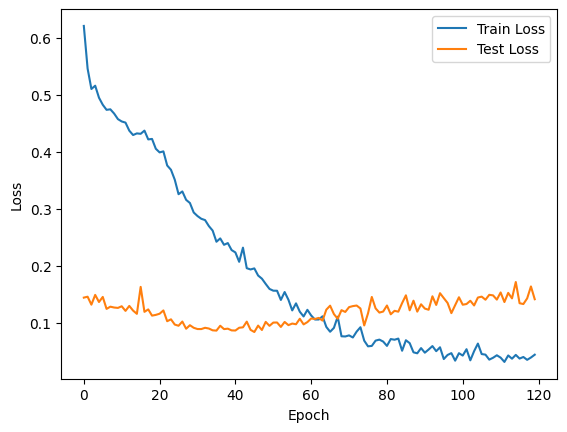

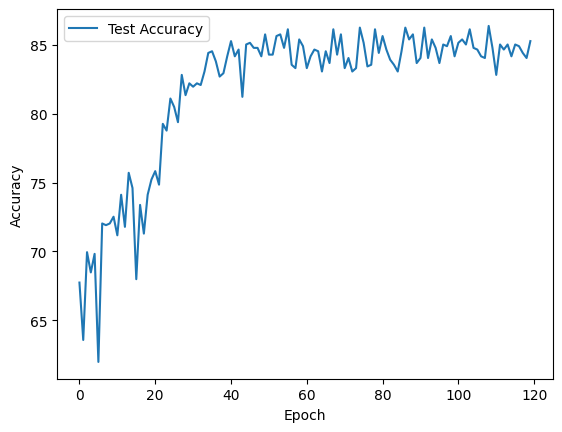

In [6]:
plt.figure(1)
plt.plot(train_loss_data, label = 'Train Loss')
plt.plot(test_loss_data, label = 'Test Loss')
plt.plot()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(test_accuracy, label = 'Test Accuracy')
plt.plot()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
